In [13]:
#Code Prototype for 1D use on EXCLAIM Project with one sensor, code by Joaquin Matticoli

In [14]:
import numpy as np
import filterpy
from filterpy.kalman import KalmanFilter as kf
from filterpy.kalman import predict
from filterpy.kalman import update
from numpy.random import randn
from filterpy.common import Q_discrete_white_noise
import matplotlib.pyplot as plt
import filterpy.stats as stats
import math
from math import sqrt

In [15]:
from collections import namedtuple
gaussian = namedtuple('Gaussian', ['mean', 'var'])
gaussian.__repr__ = lambda s: '𝒩(μ={:.3f}, 𝜎²={:.3f})'.format(s[0], s[1])

np.random.seed(24)

def print_gh(predict, update, z1, K):
    predict_template = '{: 7.3f} {: 8.3f}'
    update_template = '{:.3f}\t{: 7.3f} {: 7.3f}     {:.3f}'

    print(predict_template.format(predict[0], predict[1]),end='\t')
    print(update_template.format(z1, update[0], update[1], K))

In [16]:
class PayloadSimulation(object):
    def __init__(self, x0=0, angular_velocity2=1,
                 measurement1_var=0.0, measurement2_var = 0.0,
                 process_var=0.0):
        """ x0 : initial orientation
            angular_velocity: (+=counterclockwise, -=clockwise)
            measurement_var: variances in measurement deg^2
            process_var: variance in process (deg/s)^2
        """
        self.x = x0
        self.angular_velocity = angular_velocity2
        self.meas1_std = sqrt(measurement1_var)
        self.meas2_std = sqrt(measurement2_var)
        self.process_std = sqrt(process_var)

    def move(self, dt=1.0):
        """Compute new orientation of the payload in dt seconds."""
        dx = self.angular_velocity + abs(randn()*self.process_std)
        self.x += dx * dt

    def sense_position(self):
        """ Returns measurement of new orientation in degrees."""
        measurement = self.x + abs(randn()*self.meas1_std)
        return measurement
    
    def sense_velocity(self):
        """ Returns measurement of new angular velocity in deg/sec."""
        measurement2 = self.angular_velocity + abs(randn()*self.meas2_std)
        return measurement2

    def move_and_sense(self):
        """ Move payload, and return measurement of new orientation in degrees"""
        self.move()
        return self.sense_position()

In [17]:
printcase = 1 # If set to 1 it will print out the results
plotcase = 1 # If set to 1 it will plot results

#-----------USER INPUT STARTS------------------------------

number_of_variables = 2 #number of variables being measured
number_of_sensors = 1 #number of sensors used
process_var = 25. # variance in the payload's movement, idk what number is good for this??
sensor1_var = 2. # variance in the sensor
x = gaussian(0., 100.)  # payload's initial orientation in deg
angular_velocity = 0.5 # angular velocity in deg/s
dt = 0.5 # time step in seconds
total_time = 30. # Total time passed from beginning to end of experiment

#-----------USER INPUT ENDS--------------------------------

process_model = gaussian(angular_velocity, process_var) # displacement to add to x
n_iter = math.floor(total_time/dt)

    #NOTE: this code will assume that orientation is always increasing/decreasing and not sinusodial because a more complext Kalman filter is needed for those cases
    
# simulate payload and get measurements
payload = PayloadSimulation(
    x0=x.mean, 
    angular_velocity2=process_model.mean, 
    measurement1_var=sensor1_var, 
    process_var=process_model.var)

# creates list of measurements, NOTE: modify this section if measurements are provided
zs, ztrue = [], [], []
for _ in range(n_iter):
    zs.append(payload.move_and_sense())
    ztrue.append(payload.x)
finalposition = payload.x

PREDICT				UPDATE
     x      var		  z1	    x      var         K
 -0.078  107.250	8.235	  8.083   1.963     0.982
  8.481    9.335	10.629	 10.250   1.647     0.824
 11.833    7.794	17.116	 16.037   1.592     0.796
 19.802    5.763	18.822	 19.074   1.485     0.742
 22.542    4.755	27.346	 25.924   1.408     0.704
 30.576    4.295	33.602	 32.640   1.365     0.682
 37.963    4.092	36.384	 36.903   1.343     0.672
 41.892    4.008	40.346	 40.860   1.334     0.667
 45.530    3.976	48.406	 47.444   1.331     0.665
 52.704    3.964	48.966	 50.220   1.329     0.665
 54.714    3.960	56.219	 55.714   1.329     0.664
 60.517    3.959	62.977	 62.151   1.329     0.664
 67.457    3.959	65.703	 66.292   1.329     0.664
 71.239    3.959	66.808	 68.295   1.329     0.664
 72.335    3.959	68.245	 69.618   1.329     0.664
 72.820    3.959	69.942	 70.908   1.329     0.664
 73.520    3.959	80.015	 77.835   1.329     0.664
 81.778    3.959	88.739	 86.403   1.329     0.664
 91.771    3.959	87.827	 89.150   1.

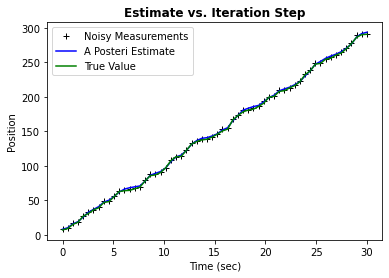

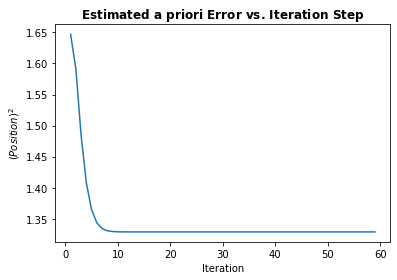

In [18]:
def plotstuff():
    plt.figure()
    plt.plot(np.linspace(0,total_time,len(zs)),zs,'k+',label='Noisy Measurements')
#     plt.plot(np.linspace(0,total_time,len(x1)),x1,'r*',label='A Priori Estimate')
    plt.plot(np.linspace(0,total_time,len(xhat)),xhat,'b-',label='A Posteri Estimate')
    plt.plot(np.linspace(0,total_time,len(ztrue)),ztrue,color='g',label='True Value')
    plt.legend()
    plt.title('Estimate vs. Iteration Step', fontweight='bold')
    plt.xlabel('Time (sec)')
    plt.ylabel('Position')
    
    plt.figure()
    valid_iter = range(1,n_iter) # Phat not valid at step 0
    plt.plot(valid_iter,Phat[valid_iter],label='A Posteri Error Estimate')
    plt.title('Estimated $\it{\mathbf{a \ priori}}$ Error vs. Iteration Step', fontweight='bold')
    plt.xlabel('Iteration')
    plt.ylabel('$(Position)^2$')
    #plt.setp(plt.gca(),'ylim',[0,.01])
    plt.show()

# x1 = np.zeros(n_iter)
Phat = np.zeros(n_iter)
xhat = np.zeros(n_iter)
counter = 0
if printcase == 1:
    print('PREDICT\t\t\t\tUPDATE')
    print('     x      var\t\t  z1\t    x      var         K')

# perform Kalman filter on measurement(s) z
f = kf(dim_x=number_of_variables, dim_z=number_of_sensors)
f.F = np.array([[1., dt], [0., 1.]]) #correct for calculating position from position and velocity
f.H = np.array([[1., 0.]]) #this is for first sensor measuring position
f.x = np.array([[x.mean], [angular_velocity+randn()]])
#f.Q *= np.array([[(dt**3)/3, (dt**2)/2],
#                 [(dt**2)/2,  dt      ]]) * 0.02 #arbitrary
f.P = np.diag([x.var,process_var]) #Variance
f.R = sensor1_var  #Noise in sensors

for i in range(n_iter):    
    f.predict()
    prior = gaussian(f.x_prior[0,0], f.P_prior[0,0])
    f.update(zs[i])
    x = gaussian(f.x[0,0], f.P[0,0])
    if printcase == 1:
        print_gh(prior, x, zs[i], f.K[0,0])
    if plotcase == 1:
#         x1[i] = prior.mean
        xhat[i] = x.mean
        Phat[i] = x.var

if printcase == 1:
    print()
    print('final estimate:           {:10.3f}'.format(x.mean))
    print('actual final orientation: {:10.3f}'.format(payload.x))
if plotcase == 1:
    print()
    plotstuff()